In [ ]:
#importing needed libraries to perform analysis
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
import os
import numpy as np
import PIL.Image
import time
import IPython.display as display
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_hub as hub
import time


#check for versions of TF
print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TF Version:  2.6.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
Found GPU at: /device:GPU:0


In [ ]:
def load_im(image_url):
  #Downloads a file from a URL if it not already in the cache.
  path = tf.keras.utils.get_file(os.path.basename(image_url), image_url)
  #Read an image from a file into an array and convert to float32 numpy array. Also add batch dimension, and normalize to range [0, 1].
  img = plt.imread(path).astype(np.float32)[None, ...]
  #checks if the pixel values are above 1, and if so, turn them to a range between 0 and 1.
  if img.max() > 1.0:
    img = img / 255.
  #makes sure the shape of the image is 3-dimensional.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  #crops image 
  shape = img.shape
  new_shape = min(shape[1], shape[2])
  y = max(shape[1] - shape[2], 0) // 2
  x = max(shape[2] - shape[1], 0) // 2
  img = tf.image.crop_to_bounding_box(img, y, x, new_shape, new_shape)
  #Resize images to size using the specified method.
  img = tf.image.resize(img, (512, 512), preserve_aspect_ratio=True)
  return img


(-0.5, 511.5, 511.5, -0.5)

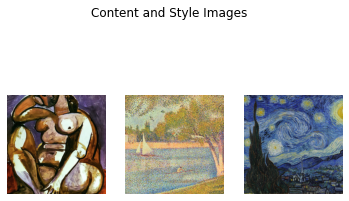

In [ ]:
#define content picture
#define style picture
style_url_3 = 'https://www.vangoghgallery.com/img/starry_night_full.jpg'
style_url_2 = 'https://www.theartstory.org/images20/works/seurat_georges_3.jpg'
style_url_1='https://images.fineartamerica.com/images/artworkimages/mediumlarge/3/crouching-female-nude-by-pablo-picasso-1956-m-g-whittingham.jpg'
content_url_1 = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFhYYGRgaGhoZHBgYGhkYGhgYGhoaGhgaGBgcIS4lHB4rIRgYJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHhISHzQrJCs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDE0NDQ0NP/AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAADBAACBQEGB//EADkQAAEDAgQEAwcDBAEFAQAAAAEAAhEDIQQSMUEFIlFhE3GBBjKRobHB8EJS0RRi4fEVM4KSssIH/8QAGQEAAwEBAQAAAAAAAAAAAAAAAAECAwQF/8QAJBEBAQACAwEBAAEEAwAAAAAAAAECERIhMQNBUQQTYXEUIjL/2gAMAwEAAhEDEQA/APLvrJSpVlNuoJY0IK4dsZl+FXvhcklNvw8qvgomUKgUXkJiZXG0FdrEWSpWpOIRg5UYxFDFFyOA1GSlajE+4KpYnMzL4elujPpSiAKAo51NVcICFSBlNNZKK2iFWOdIo5qE9ieexBcxactq0SFJXaEwaS4KaLYWnA1da1WaquEqMqBmBEYxDpsTjGLCnIA9iE5i0LKhpSinrRNrFfImBSV/DTmQmVhLKqkXT3hobqUqpkfOuU6llRz5VnUiqikUcq0v2o7Sh1ArBpChajlV/wB89ggISuOfLiqU3lqq+6fJc++Ng9OlYKITaiirlD/uYg+Iguur2XIWTjBAVwwIoZZRlNLWiVDF0UEwGQiMCrYKhigYnDSVDTSsIDw100EZjYN0y9wIRIcIeAu08ESfv0TtNhLgACSdhqfJeu4FwTRxuOhGx/P8AhafPC5U8Ztk8M9knPyuLoG/2hC4/wAA8AtykuBFyeu6+kUsLlADRACXxmADxDhIXRl8ZrUacJY+TGmCqCgF7Xivs2XEuZrYAbABYlfhNVglzCAN4t8VzZY5Y/jO45Rlf0iBUwq0RURGU82gk9N1MyEuLEGGKNQwRLgF6zAcJBuI8j9Foj2fbq23Y7HqIXTj8rZs7jvx5Wnwd2kfn3/O6M/hDmxOh32Hn/K9rhcGYhw5haRv0ITgwoIggd/5Vf8AHxsPi+ZYjAvYYI/PwKrGL6Pi+FMe2IFhHp+QvLcU4OWczRbcd4/wVh9f6fLHvHxOWNjEDFV7EyWQqwueMtlgxWZSRgFZxTGy72KBiuQrsCns5Sz2KgamnsVMqOVUCWLmRMZVMiOVBbw1E1kUS5UMElWY9UdJC5SaVvcdGap1EUOSrWK+ZAN5rKNelw9da9A2eY9QkJV1RBNYoo2fe4LjQlWOlTG4ttFrHPmHOI06RmPkMzb6XCcxuXUEm/Hu/Z/grXMY92tiNv8Aa9nRAAssH2Zeyrh6b2VHFhgyWgOgasIuBpC2MbVawSSu7DGY46b446NGoFV71n0q0hXc8p7VpR+LDXZZEofEnh7Mk+8D6BZrsK91cX5dSTsB0TWIqNL7HSyi3prwjw3EMP4by07LQ9n2h5ykCRcHf0OoWhxvhjXNLw0k621XmuF4vJWYdLwZ6d1y64Zzfjiyx45PpOHw43CbZShcwxloKZAXoNdB+Gu5FdSUbPQTmJXEYYOEEJ5xQnoLTx3FODnOS3Qtn1AgrzTmEWK+oVGAi/5K8Xx3CWzgQMzo8rD6g/Fcn3+M1yxZZYa7jCaqPcjVKeWx80u5cNtl0y07mVc65KsGJWmqKiLmVPDV3MRAoSql8K4YuZUqenfEUXbdFE+gw3vC450K1Rt0ZtIEXW9qghVVXPgLgwpmQmDQ5e6Wy0Ax1lSYKZZhzC4MNe6VPQReqwUy6hddc0BMaCw4JW8yiypSoOeyfCc9riBZrXkGSP2nSf7Vj0wZsF9K9n+BhlDm994knp0ELf8Ap92qw9OcMc1jGsY0NaNAAAOuyyPa7hL8VTa1pEtdmAdJYbEQ5u4vPomBh3sOVpAjQRaOx6LSwjyRLl1N4zfZ2jXZSYyvlLm2DmSZbtmB0PxW20K7XLspaPYWUXKyiG5oaR5Bax6JDwhmJi+6jONMaPSZIgrCxnsg59UPa8BpImRdo3jqV6HDhNZ4CfHHKdsssZlV6FMMaGt0AAHojApdr1cOWkpWDFyoXoTnoT6idoHNRUc5LPqrrakqeQ0K8rNxtBroze638JT2ZAxDJBHXXy6KvYnKPB8RJc5zhZu3cSVmCpstXjrneIRoBoLQLdAsR74K8n7TWVc+uxXC6swlBNVcFdY2yelo6XLnioLHq5bKe5aBWPUcVVlKFUtKroWO5lFIUS6MsaAvKVqYY7I2IqXCPQIIW3qi/urj6qOaBOqo9g9U/CU8VUfWJ0RxhxEqzMOBdI9K0wI5tVHMCj28ysWXumT0Hsnwlr3+I7RpsOpX0Fq897L4cMpN6m59V6FpXf8ALGY4xtjNRStSB2XPACICrrSrDyIdQIzyhPcFOj2E1ndVe2JKj62yXLz6FKw9jserVHqjGRdCe75ovgnplj0Vz0i1yYY6QljTyjuZWDFUBWa5VErhiqacaIgKhT0QBag19OiaIVXMHREFfPeOOh5ADv8AuET3sseoydl9B43hmlpdlBIHqF4atM6Lz/6jC45W/wAsMsdFKdA7qrqUFOOlVfS3XJYkOEZj0JoXS8BTLJdloz4gXM4S7SCoagVXKDRnxAolVEbg7VzgtuLqMaI5VnU6kEybHRM4apMwtuWqZprzoqtMmChB95nUo4DQU+UG1S6LLlOreDoo6mC6Roqvw7gEt38PYjmAnVG8O0pZlI2jVGl0gaBVCj6D7N/9Fh/tH0WwCsnhFQZGgaAAfBaTSvTx/wDMdE8HChehyhvcmblR6DmJVyFBZLQDc3dSmySo58mEegEtBctgJQNunKuiXARYcqhYrsaqu6qwdolIdrsmUVqC10lFlPSRZXC5UcVUpgSVzMqX6rjpRADjqOdhixjUarwGKaWucDqCvoJesnjOAa/mEB3181H0w5Rlnjt4ek8ucQq1HkGEXE0i1xg6LjKUmSvPyw0yCpqzmWTApwZXWs1lZ8DLU2Kr2BMMaAYVnUhCf9voAZFEaFEcP8EwqFMuJmw2RGDJMK1KoCCuEkkTEK+MU44Gx6/VHcwhw+aTxL7w0/wERznGLzy3lVwlKmH4vKbX/wAopxM5RO9wsd+4IIIBBn5I+HdPNbT4ImPYbNN5k2gRZWbzDySz8ZAB1Gi5SxQuYidkrOz0917PVszI2Fl6Brl4v2V4gCcm5/CSvXAr0Pld4ytsfB8yG56G56VqV4V2maNUBLVa+yVfXVWOMqbQfY5O0Ss5h0TbKicA73JcvXKlVK1aiY2ae9DNS4Sbq5susfKVoaLOqICl6Rsr5wEBdzlzMqBXaEGK3uuuKqHIb3pwth1XLLx2MDRqPIpvEVF4njeIJflnTcbqc8uMRllqOcQeHk5RBSNF5BgrlRlswJsgioHmGg9yuHK7u2G2gysJhdDwk/6c/uXK2ILABYkqTlgj3mVanXJ0VaTwRcXVnUwLixRDt0N4h6qLM/pX/vUS2e4y3PI9TFkbKQAZ31n7IUGCTYDRVNQxe3z36Ktfqrocua106mN9PVCbV5w4mxMdoPRWrMBHWBfbdVokRMSQLDodir8pGMS8gcwLjlk5b6WQGvIcTq0gf6RsmZwIsb76zbKOnn3S7KgYXNF3X8gbJ+kKKtyDpaOx1RGVMvMRIBj1PfsknudkcXbkC9r6W6rhrcmUaD6lLQsen9msXkqsPY/PfyX0PDYgOuCvjlCuWi03j0A2C9bwT2ga3lOgEfhW3yyk/wCtXjlr17DE17wNfy6Te+8SqNxIcM0679kJlWb6fwt6vY4N7I7DF1kvxV4ARGVHQp2NtFuIJMphlTdYWctIN01hsb18kTIz7qsmJ8kGvWsRuPz+EriXnbsk8TiTnA2tP58PgntJuvX185+V/ui4N5cR5rGfiZbPf8+60sJWguOzbeZOnyQG26psr00rgqZNzutEMTU6wIgCHBXC5MLPMFArOV3vWdisRCYBxr+UwvE41jnP+69DjsdAPRedeHZ82bsQub7XfTDOjUnW1mBdDaJuAIKq8tDYDpO/kl2gEkXjssGSlTCPe8lpjpdFwnDz+syj0g0aGCNkR1UtJzaHSFMnfZ76DdTIeIQMZRc9wA+qs/EOOu50CvTY0Wkjz3R74N9kncMqfvUWu1/ZdRxh7eRc8gmTcwPTy8ld7bAiCAJIiAREwfmrQ0F0jMWQY6aTP0VRVIBcS1o6EWgibCJPor1Z006UZVEAm83HYdCFMPUJm2jfKTogV32knlA1/cftcqtIvaCXCxFpvMkXtsEuJVpU3gtLn8giAdS636W/clL4h9MAuFiSNTzExN/iln1HuJBINpaBcWJm/WfoEXD1YcSbRAIzenKIV716NOFz3tEh0bOJMNi5kbWUNaQLEAG5i56FOVsXpDCRHukkCO6I6rDByta1206CbZhF/wDCDhRlcGw/URqNheLXRK7oALYk2tsdTA+6YoYYkyLH9OSIMjWNd1StgzF3kkNmSBbMYsew/LKbVab3sxjy94pSTIJPQQFs4tzmSPyF5r2OohmJYX2gkdiSIEle84vhQ4Lo+d3irHx5lnERIB1Nh2816DDUZAK8pxDD5TIXouB4w1GTu23r1+CvH+Kej76AhKvwu60XOQ6jhF1XE2Ri3EXnp/pZ+Jr7+f8AhX4vig2R6rDxOMtr0I/lRlZE2n8RiA1oHWPr/lOcKx2bK3oAT3MASfQBeQq4yTqC60T13TnDMZkcSSdpnpOn0UY/TtO6+p4KpZPiqvLcL4mwi7gtunXB0K6FynvECG5+6BnVHP1QaYmpYrzPFeKATsR21TPGuIZBE7WXihi3O/UDfSPyVj9c+PUZ5ZDV+IF9y4DtGqW/5BptBnc91arWE2E2jaAdZS2W4LiN5A3XLbd7Y06K7Tl5I6kK+Vsy2WmPil6zGFouSdss/NTxS0Q0Zi4EnNYNA6pyCwxhntLy7pqXfZEfiM/KDmbOsQG9pSdBroh8dZEy4fZFq1HNbytAbffQfyiwoJ4oDy0iA39XXyVczXuBBzXsdAFUMBZJgyb7mAdj8fgu1qjgBlaMvml+bNerxItJAZooqNok6x81E9DTMqUMjYIBbaZnW4kunoEPiNANaxxIeXzl1ADdBm+IEBPPwpewyRJsMtvdFt9YtcotN0NGYZMoLedwcGx+4/AnzTl30vcY2Eo5ZzFoaW8wdMAWka2JEabIlKkxoecxcwCQXDlLoJAv3gX102Wr4DHsdlAJOUuI0BOuU7jvGyHiOHAOEPAAILgc2U+bp2vaU6cv6xMHSe4gC8w0AWALhMkeaao8Ke0kugkCZMRfr0Nx8FtUqIaRvDw4EAyW2MWibidFwEB5PU3EbCTptupt1StJ4fBmDmFxoZjaZyjsDr1R8RSY9oY6cwnUCQdJDpvCfr5AJiTN9JB6SPI/lki9jWnnkgG2WAAf3Ze9vIFK3sOYbD5A2HOO9wRIGoBAtqdVMSHktIsHATMCRt6fyo/WbBjmgnKTMyCQSdTG1tewXKzy6P2hojpI3y3gQot73VS9NTg2DdUrsEgQ7O4gwGtYZkk7EDtsva4mqwAnM2DcEGQ6wuHbi4XiBiGimQ0EF7CKlzDhIcBEkxbyubXWXxXHmoGPeLnkzOJkkaxLoi8dNd1vjlMJ0MctNjjeNbGdhDm3uDItrBCV9juMDxyw2FQW6Zmz/lYtZ7nU2k2BcMobGWSfdiNYHml8RgXNGdgJJIjKHBzTFoEWurv07lVy/X1sOE3KDiX8pJWZg+I0jTa+o8tdlEyDrlB2FjrZI4n2kovzMZmgAyYIvtEi4N1pM8f5Pc08z7QY7mlhB17fJZIxOaADc2vJ+HqmcWM7zkaSbzy8xPSB6JF2DfqWFvfcAa+Syy1btO3HmXD9NifjIjsutquc6WxbWdOk2VGQReRB851sR8U1ToFrhGkzoYiNSfWFJbDpcRe0WJN9jbfffT5r6n7JYg1sOx5PNcO8wfz4r5T4URl1gGI76Svff/lVZ721mHRrg7r70j/5W3zu6qXt7Nz41SmLxbcji0gkCY3si4viFBrsniNL5LS0EcsAk5ugtHmQvnPtS95qhzM7SXQIBEkXtGsAqrnIdoXHOLOe7qAbjeNp+CyqbyHGHWP0tMKeG5zjmJv0Bm2oAXC8XLT5AwMwEEcoJlYZXbKumoc0tFiYgny0TReBtLTodrTM97IHiNnnIadx5myPUoAFjQQ6XRcTEkS4gbBRrohcJUJElruUWP7r7AGyJm5pMkuIESeUTElMCkSHljWgtkSCACdGnp+nt7294Sw0mXEGxANrGbiT6FK5UtH2OM6i9ubYz532+Ks6nBAe7M1xuOg1gecFBIDnAgaEmIGgvqekFXxAGZ0e+HH/AMZIm+llNs0euw8RWa2GgGTG9hoI+qaL3nlaGhosXET8O6SzAQYkaBxtr0smnhrYDiItAHfsjHWivu1/C/u+aiQqBoJF/Sd7qJFp2hRMk5rA6OiBoAMoPSIE237nxDczS3KXAGcoAdppaeo76pdlEAbw6RJOvp8pTILolgzHSXSIveBuDe6Me2liOrhjOha2Tq2Tu0NFpJgabJejjQ9ohnMSLOFjp3vrKYFJrrvBzfqzWafgPyypTwtxBzQZmLnTlA/b3+CqTRXt3F1rZYc3SzBaLCCdRfYbeqTwAexzqhDjqC2ZBki4nSwHVOmnc3aCLbxJNgCphsNlMkm1tIg9I3HdFysH+nS9xOYPLZjvHodkZ4BaTDXui/KG6bDp3PmlKjeaQ4EtEm999OuycwhGufLa+bXtpbcqccvxOrQ8OCIke9bTqdCenZHa0MF9IuIgHt2/LKjIfcw8C4lup0Lj0Oys+xknORByiCASYFh+WVXrwv8AYbXtc8ZmlpJmWEBpA2duQr4+C5plmYEMgtBjNGkXmRrYeaBUwzJlzCZnTvefkoKOWdSQJB+QEdeyVuvT2rjMMxmrnEOIJZmgAtuMsa3g+pTDcmQBlnCIAGYjqL3J116oOHrkakgmbGIgxlNtdSfRUxHECzMxnMYkDUk9QBcCY1Sl3sdqVabmSDLhA0kEEGYjZ0mPJJPBeS5gIMmbStCgwvYC8GSSTfQ33TeJeA0s8TLFyBLnQRuB1Maos66Lf4y6FN0S0uJJygDUAm5hpFgZJ+8oNLhTnuc55yl7nC8hzWAdrZiLCeh6ptmIFnObBc6Gg8psCJBJAvA+3RNYbESXFoAIm0QXzIkOOuguE+WuoudM3h+Fpl7mu5byzOM3bKXEe8dx/ciVuGHLlll7kklsgG0MEjTZa4tnDhByiXZ5h1/eAEA3n1VPBeAcrA8a3NojRvVVym020jT4XUAzEMcYgCzS4a2J6z9eq06WMfQpVGMyhzyMzmcrmiMoAfOtzsSZi2qSw+dhykO0u8vluY6Q0m0aaBXyhjwA3ODJiZOt4vLSCQU5l/HQm99M5jzSkhpzkWtJF5mCL7ItPFPe0kgZ7smZOxd3APS2yaoU2ucHQCGuIjVzidiSbxqfojVsTTZLgAIEmSLaX+iU7n+DtrNc5wZmAbflNhaPe+IuL7ldwzGB2UNbzCGgm+WJi0botHEMcHuaWmBbI3RxdIt1uuYeq0AOJzOggDLGVw6yO+3RSV20mBmUtDC6GFozQ5rXO/WGSOYm4M6ALPrUchDMsvEFxaSRe+8R0/0pTxri9jHBrSQb35iLAtAPn81oeC2MxgvDcozEiY0nVVsWs/CwS4jlkRYukydr63j0TVYQwsa3KGSBIm5hxeY72HkeqXa2ox4ytGlyAT2jMQBsNOqM2o5rZe8Ak8sAnUDl0mxm/ZR3+gGlgsrM5POQdTywRB0kW0t1QcRTBcc5c0xNu0d7Tp/tMYmvLcpBMaxMEWJnobD4KraucjM0OB62NgIPc2Oqm3vR7d/ppZZriOmgm3ujzn4BFBygWzGAe8m8T5K+JY54HMWtiSG/p1At84nolnugjmtYt3NuoGpTmp0Ep1IHvRc26XK4lKjyST1UT5GbxQD8lgJnyEFUhwmLN2uZ7W+JUURpYgfyy7YWm6thi7LY973MT12XVFJK0eaS7m3M9tB6K5wxfBFheLmcp2/OqiiePhTwvVwYpAAkOIB6ixOlui64t066RPTqoonZ2PwarTdkBIGUmIFiepJClClBEGBAJ6m0Az11+Kiin9KgPqDQOMidZMeSIHOLRA02tcriiPfSNtouaAYBdAmY1IvBHmqU8IwDPAlsGTMmLkaW1+SiiZwUP8QZhy9tvRcY4B0SbzPdRRXWf6WHD8zgXPtoGwI6iLW2Uo4aXw3prMW1t0UUU1pB3YQBovPMSc2piLSFelSMEtIhpmDMAgTI6qKIvsTvsD+qa1zv1W0iL2ywg0KhL8hNsto1knr5BRROSbitHKxfmBEAzYbT9tdUriQwvDHMGWZkRcTlMg6mJXFEX1ENtw9Oi3K0FrTLp1vYdygNoU3vN7gac25sTIjbZcUT9OnsNhmtAef02BFsoE2trqlm4nNcCWzfQETobqKKKKJi8GCID3SepJEToR/Cy8TmL7kkTvAEmwsNh9lFEznhv/jp/wDbNa+xHUfBdOEfOZoblbETrG/3UURZCKBrnS4ElswQTbm+cK1JhAkjWYdJkQdI73+KiihSeFP6j8T/AAooomT/2Q=='
content_url_2 = 'https://image.newyork.co.uk/wp-content/uploads/2020/11/Flatiron-Building-in-New-York-View-335x252.jpg.webp'
content_url_3 = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6Dwv-p2OCi2hlufuRUgimLCVwoc2rvbxOJcxDm-JJWxfMyRbS0xYUq1lnYAQvC2aTzXM&usqp=CAU'
#load and show images
content_image_1 = load_im(content_url_1)
content_image_2 = load_im(content_url_2)
content_image_3 = load_im(content_url_3)
style_image_1 = load_im(style_url_1)
style_image_2 = load_im(style_url_2)
style_image_3 = load_im(style_url_3)
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.suptitle('Content and Style Images')
ax1.imshow(style_image_1[0])
ax1.axis('off')
ax2.imshow(style_image_2[0])
ax2.axis('off')
ax3.imshow(style_image_3[0])
ax3.axis('off')


(-0.5, 511.5, 511.5, -0.5)

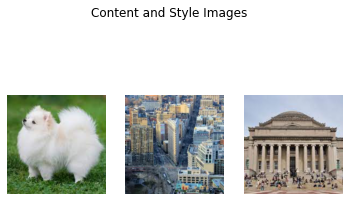

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Content and Style Images')
ax1.imshow(content_image_1[0])
ax1.axis('off')
ax2.imshow(content_image_2[0])
ax2.axis('off')
ax3.imshow(content_image_3[0])
ax3.axis('off')

In [ ]:
#processing image to the requirements to utilize the vgg19 model
#as per keras documentation, function converts color scale from RGB to BGR, 
#then each channel is zero-centered with respect to the ImageNet dataset, without scaling.


x_1 = tf.keras.applications.vgg19.preprocess_input(content_image_1*255)
x_1 = tf.image.resize(x_1, (512, 512))
x_2 = tf.keras.applications.vgg19.preprocess_input(content_image_2*255)
x_2 = tf.image.resize(x_2, (512, 512))
x_3 = tf.keras.applications.vgg19.preprocess_input(content_image_3*255)
x_3 = tf.image.resize(x_3, (512, 512))

In [ ]:
#printing the preset VGG19 layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
#defining content layers. These are the layers which will capture internal representation of content information.
c_layers = ['block5_conv2'] 

#defining style layers. These are the layers which will capture internal representation of style information.
s_layers = ['block1_conv1','block2_conv1'
,'block3_conv1','block4_conv1','block5_conv1']

In [ ]:
#creating function that returns the grouped layers of the list of inputs of the model and chosen layers from VGG19 from the above cell.
def layers(layer_names):
  #calling model
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  #freezing weights of layers
  vgg.trainable = False
  
  #get the output layers
  outputs = [vgg.get_layer(name).output for name in layer_names]

  #finalize layers
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
#function calculates the gram matrix that includes information of correlations and means across various feature maps through finding the outer product of the feature vector with the outer product of the feature vector at each location, and finding the mean of the outer product over all locations. 
def gram(input_tensor):
  result = tf.linalg.einsum('hijk,hijl->hkl', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num)

In [ ]:
#defining the style/content model
class mod(tf.keras.models.Model):
  #layers component
  def __init__(self, style_layers, content_layers):
    super(mod, self).__init__()
    self.vgg =  layers(s_layers + c_layers)
    self.style_layers = s_layers
    self.content_layers = c_layers
    self.num = len(s_layers)
    self.vgg.trainable = False

  #call component which calls vgg19 and calculates style.
  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(inputs)
    s_outputs, c_outputs = (outputs[:self.num], 
                                      outputs[self.num:])

    s_outputs = [gram(s)
                     for s in s_outputs]

    c_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, c_outputs)}

    s_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, s_outputs)}
    
    return {'c':c_dict, 'st':s_dict}

In [ ]:
ex = mod(s_layers, c_layers)
style_targets_1 = ex(style_image_1)['st']
style_targets_2 = ex(style_image_2)['st']

content_targets_1 = ex(content_image_1)['c']
content_targets_2 = ex(content_image_2)['c']
content_targets_3 = ex(content_image_3)['c']

image_1 = tf.Variable(content_image_1)
image_2 = tf.Variable(content_image_2)
image_3 = tf.Variable(content_image_3)

In [ ]:
def clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.9, epsilon=1e-8)
style_weight_1=1
content_weight_1=1e5
style_weight_2=1
content_weight_2=1
style_weight_3=1e2
content_weight_3=1e5


In [ ]:
def sc_loss(outputs,style_targets,content_targets,style_weights,content_weights):
    style_outputs = outputs['st']
    content_outputs = outputs['c']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weights / len(s_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weights / len(c_layers)
    loss = style_loss + content_loss
    return loss
def train_step(out,style_targets,content_targets,style_weights,content_weights):
  with tf.GradientTape() as tape:
    outputs = ex(out)
    loss = sc_loss(outputs,style_targets,content_targets,style_weights,content_weights)

  grad = tape.gradient(loss, out)
  opt.apply_gradients([(grad, out)])
  out.assign(clip(out))


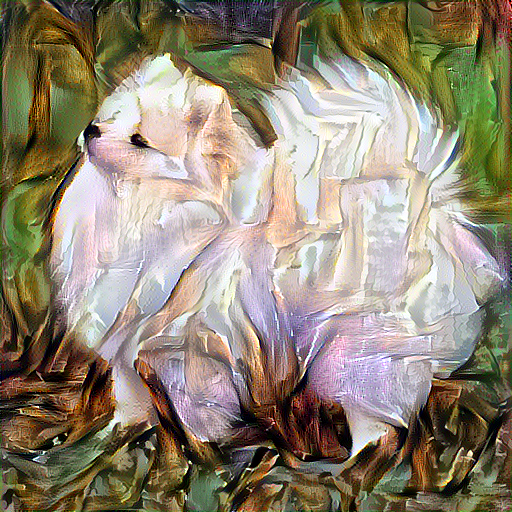

Train step: 1000
429.81121301651


In [ ]:
epochs = 10
steps_per_epoch = 100
step = 0
style_targets_1 = ex(style_image_1)['st']
content_targets_1 = ex(content_image_1)['c']
image_1 = tf.Variable(content_image_1)
step = 0
with tf.device('/device:GPU:0'):
  start = time.time()
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image_1,style_targets_1,content_targets_1,1e2,1e6)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(np.array(image_1*255, dtype=np.uint8)[0]))
    print("Train step: {}".format(step))
end = time.time()
print(end-start)

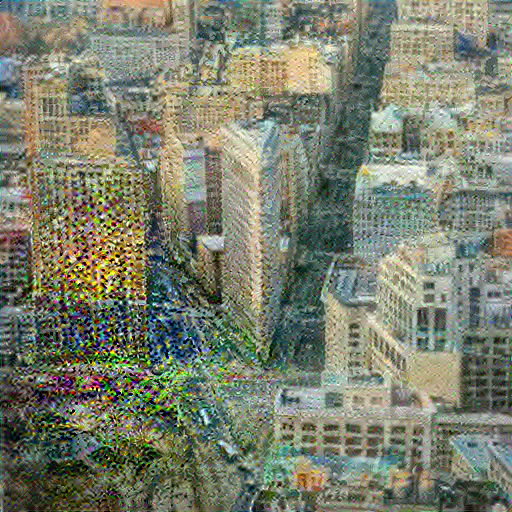

Train step: 1000


In [ ]:
style_targets_2 = ex(style_image_2)['st']
content_targets_2 = ex(content_image_2)['c']
image_2 = tf.Variable(content_image_2)
step = 0
with tf.device('/device:GPU:0'):
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image_2,style_targets_2,content_targets_2,1e-2,1e6)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(np.array(image_2*255, dtype=np.uint8)[0]))
    print("Train step: {}".format(step))

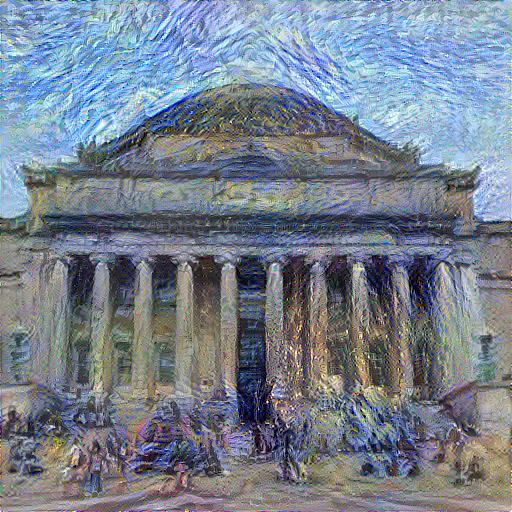

Train step: 1000


In [ ]:
style_targets_3 = ex(style_image_3)['st']
content_targets_3 = ex(content_image_3)['c']
image_3 = tf.Variable(content_image_3)
step = 0
with tf.device('/device:GPU:0'):
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image_3,style_targets_3,content_targets_3,1,1e6)
      print(".", end='')
    display.clear_output(wait=True)
    display.display(PIL.Image.fromarray(np.array(image_3*255, dtype=np.uint8)[0]))
    print("Train step: {}".format(step))